In [3]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'
os.environ['LD_LIBRARY_PATH'] = '/home/nazar/.mujoco/mujoco210/bin:/usr/lib/nvidia'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g, z), g - dim 29, z - dim 256
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g ,z ), g, z - dim 256
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, z=None)) 
def eval_ensemble_gotil(ensemble, s, z):
    return eqx.filter_vmap(ensemble.gotil)(s, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)



pybullet build time: May 20 2022 19:45:31


In [4]:
from jaxrl_m.dataset import Dataset

from jaxtyping import *
import dataclasses
import numpy as np
import jax

@dataclasses.dataclass
class GCDataset:
    dataset: Dataset
    
    p_randomgoal: float
    p_trajgoal: float
    p_currgoal: float
    geom_sample: int
    discount: float
    p_samegoal: float = 0.5
    terminal_key: str = 'dones_float'
    reward_scale: float = 1.0
    reward_shift: float = -1.0
    terminal: bool = True
    curr_goal_shift: int = 0
    
    expert_trajectory: ArrayLike = None
    expert_subgoals: ArrayLike = None
        
    def __post_init__(self):
        self.terminal_locs, = np.nonzero(self.dataset[self.terminal_key] > 0)
        assert np.isclose(self.p_randomgoal + self.p_trajgoal + self.p_currgoal, 1.0)

    def sample_goals(self, indx, p_randomgoal=None, p_trajgoal=None, p_currgoal=None):
        if p_randomgoal is None:
            p_randomgoal = self.p_randomgoal
        if p_trajgoal is None:
            p_trajgoal = self.p_trajgoal
        if p_currgoal is None:
            p_currgoal = self.p_currgoal

        batch_size = len(indx)
        goal_indx = np.random.randint(self.dataset.size, size=batch_size)
        final_state_indx = self.terminal_locs[np.searchsorted(self.terminal_locs, indx)]

        distance = np.random.rand(batch_size)
        if self.geom_sample:
            us = np.random.rand(batch_size)
            middle_goal_indx = np.minimum(indx + np.ceil(np.log(1 - us) / np.log(self.discount)).astype(int), final_state_indx)
        else:
            middle_goal_indx = np.round((np.minimum(indx + 1, final_state_indx) * distance + final_state_indx * (1 - distance))).astype(int)

        goal_indx = np.where(np.random.rand(batch_size) < p_trajgoal / (1.0 - p_currgoal), middle_goal_indx, goal_indx)
        goal_indx = np.where(np.random.rand(batch_size) < p_currgoal, indx, goal_indx)
        
        return goal_indx

    def sample(self, batch_size: int, indx=None):
        if indx is None:
            indx = np.random.randint(self.dataset.size-1, size=batch_size)
        
        batch = self.dataset.sample(batch_size, indx)
        goal_indx = self.sample_goals(indx)

        success = (indx == goal_indx)
        batch['rewards'] = success.astype(float) * self.reward_scale + self.reward_shift
        if self.terminal:
            batch['masks'] = (1.0 - success.astype(float))
        else:
            batch['masks'] = np.ones(batch_size)
        batch['goals'] = jax.tree_map(lambda arr: arr[goal_indx], self.dataset['observations'])

        return batch

@dataclasses.dataclass
class GCSDataset(GCDataset):
    way_steps: int = 25
    # high_p_randomgoal: float = 0.3
    
    def sample(self, batch_size: int):
        
        indx = np.random.randint(self.dataset.size-1, size=batch_size)

        batch = self.dataset.sample(batch_size, indx)

        final_state_indx = self.terminal_locs[np.searchsorted(self.terminal_locs, indx)] # find boudaries of traj for curr state
        way_indx = np.minimum(indx + self.way_steps, final_state_indx)
        batch['ailot_way_goals'] = jax.tree_map(lambda arr: arr[way_indx], self.dataset['observations']) # s_{t+k}
        goal_add = np.random.randint(1, self.way_steps, size=batch_size)
        way_indx_2 = np.minimum(indx + goal_add, final_state_indx)
        batch['ailot_subway_goals'] = jax.tree_map(lambda arr: arr[way_indx_2], self.dataset['observations']) # s_{t+[1,k]}
        
        return batch

In [5]:

import random


def actor_loss(model, obs, actions, v, next_v, goals):
    adv = next_v - v
    exp_a = jnp.minimum(jnp.exp(adv * 10.0), 100.0)
    actor_dist = eqx.filter_vmap(model)(obs, goals)
    log_prob = actor_dist.log_prob(actions)
    loss = -(exp_a * log_prob).mean()
    return loss


def intents_loss(model, obs, goals, key):
    z_dist = eqx.filter_vmap(model)(obs)
    z = z_dist.sample(seed=key)
    return jnp.sqrt(((z - goals)**2).sum(-1)).mean()
    # return optax.l2_loss(z, goals).mean()


def ot_intents_loss(models, obs, goals, key) -> float:
    z_model, v_model = models
    z_dist = eqx.filter_vmap(model)(obs)
    z = z_dist.sample(seed=key)

    v = eval_ensemble_gotil(v_model, obs, z).mean(0).squeeze()     
    an = v / v.sum()
    bn = jnp.ones(goals.shape[0]) / goals.shape[0]

    geom = pointcloud.PointCloud(x=z, y=goals, epsilon=0.001)

    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        a=an,
        b=bn,
        x=geom.x,
        y=geom.y,
        epsilon=0.001,
        static_b=True,
        sinkhorn_kwargs={
            "implicit_diff": imp_diff.ImplicitDiff(),
            "use_danskin": True,
            "max_iterations": 1000
        },
    )

    return ot.divergence


def pretrain_agent(
    env,
    icvf_model,
    gc_dataset,
    expert_trajectory,
    num_iter: int = 6_000,
    batch_size: int = 1024,
):

    key = jax.random.PRNGKey(42)

    intents_learner = TrainStateEQX.create(
        model=GaussianIntentPolicy(key=key,
                             hidden_dims=[512, 512],
                             state_dim=29,
                             intent_dim=256), 
                             optim=optax.adam(learning_rate=1e-3))

    actor_learner = TrainStateEQX.create(
            model=GaussianPolicy(key=key,
                                 hidden_dims=[512, 512],
                                 state_dim=env.observation_space.shape[0],
                                 intents_dim=256,
                                 action_dim=env.action_space.shape[0]),
            optim=optax.adam(learning_rate=1e-3)
        )
    
        
    intents_vg = eqx.filter_jit(eqx.filter_value_and_grad)(intents_loss, has_aux=False)
    actor_vg = eqx.filter_jit(eqx.filter_value_and_grad)(actor_loss, has_aux=False)
 
    @eqx.filter_jit
    def make_step(intents_learner, actor_learner, batch, key):
        obs = batch["observations"]
        next_obs = batch["next_observations"]
        actions = batch["actions"]
        goals = eval_ensemble_psi(icvf_model.value_learner.model, batch['ailot_subway_goals']).mean(axis=0) 

        sampled_goals = eqx.filter_vmap(intents_learner.model)(obs).sample(seed=key)

        v = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, obs, sampled_goals, sampled_goals).mean(0)
        next_v = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, next_obs, sampled_goals, sampled_goals).mean(0) 

        intents_cost, intents_grads = intents_vg(intents_learner.model, obs, goals, key)
        
        actor_cost, actor_grads = actor_vg(actor_learner.model, obs, actions, v, next_v, sampled_goals)

        intents_learner = intents_learner.apply_updates(intents_grads)
        actor_learner = actor_learner.apply_updates(actor_grads)

        return intents_learner, actor_learner, intents_cost, actor_cost
        
    pbar = tqdm(range(num_iter))
    
    for i in pbar:
        key, sample_key = jax.random.split(key, 2)
        batch = gc_dataset.sample(batch_size)
        intents_learner, actor_learner, intents_cost, actor_cost = make_step(
            intents_learner, actor_learner, key=sample_key, batch=batch
        )

        pbar.set_postfix({"intents_cost": intents_cost, "actor_cost": actor_cost})
    return intents_learner, actor_learner
    


In [6]:
def train_gotil(
    env,
    icvf_model,
    gc_dataset,
    expert_trajectory,
    intents_learner, 
    num_iter: int = 6_000,
    batch_size: int = 1024,
):

    key = jax.random.PRNGKey(42)
        
    ot_intents_vg = eqx.filter_jit(eqx.filter_value_and_grad)(ot_intents_loss, has_aux=False)
    
    @eqx.filter_jit
    def make_step(intents_learner, value_learner, batch, key):
        obs = batch["observations"]
        
        sampled_goals = eqx.filter_vmap(intents_learner.model)(obs).sample(seed=key)

        T = expert_trajectory.shape[0]
        goal_add = np.random.randint(1, 20, size=T)
        way_indx = np.minimum(np.arange(0, T) + goal_add, T-1)
        expert_goals = eval_ensemble_psi(icvf_model.value_learner.model, expert_trajectory[way_indx]).mean(axis=0)
        
        gotil_cost, (intents_grads, gotil_grads) = ot_intents_vg((intents_learner.model, value_learner.model), obs, expert_goals, key)
        value_learner = value_learner.apply_updates(gotil_grads)
        intents_learner = intents_learner.apply_updates(intents_grads)
        
        return intents_learner, value_learner, gotil_cost
        
    pbar = tqdm(range(num_iter))

    value_learner = TrainStateEQX.create(
        model=icvf_model.value_learner.model, 
        optim=optax.adam(learning_rate=1e-3)
    )
    
    for i in pbar:
        key, sample_key = jax.random.split(key, 2)
        batch = gc_dataset.sample(batch_size)
        intents_learner, value_learner, gotil_cost = make_step(
            intents_learner, value_learner, key=sample_key, batch=batch
        )
        pbar.set_postfix({"gotil_cost": gotil_cost})
    return intents_learner, value_learner

In [21]:

def intents_loss_gotil(model, obs, v_model, key):
    z_dist = eqx.filter_vmap(model)(obs)
    z = z_dist.sample(seed=key)
    loss = -eval_ensemble_gotil(v_model, obs, z).mean(0) * 10
    return loss.mean()


def train_agent_with_gotil(
    env,
    gc_dataset,
    actor_learner,
    intents_learner,
    value_learner,
    num_iter: int = 6_000,
    batch_size: int = 1024,
):

    key = jax.random.PRNGKey(42)    
        
    actor_vg = eqx.filter_jit(eqx.filter_value_and_grad)(actor_loss, has_aux=False)
    # intents_vg = eqx.filter_jit(eqx.filter_value_and_grad)(intents_loss_gotil, has_aux=False)
 
    @eqx.filter_jit
    def make_step(intents_learner, actor_learner, batch, key):
        obs = batch["observations"]
        next_obs = batch["next_observations"]
        actions = batch["actions"]

        sampled_goals = eqx.filter_vmap(intents_learner.model)(obs).sample(seed=key)

        v = eval_ensemble_gotil(value_learner.model, obs, sampled_goals).mean(0)
        next_v = eval_ensemble_gotil(value_learner.model, next_obs, sampled_goals).mean(0) 
        
        actor_cost, actor_grads = actor_vg(actor_learner.model, obs, actions, v, next_v, sampled_goals)
        actor_learner = actor_learner.apply_updates(actor_grads)

        # intents_cost, intents_grads = intents_vg(intents_learner.model, obs, value_learner.model, key)
        # intents_learner = intents_learner.apply_updates(intents_grads)

        return intents_learner, actor_learner, intents_cost, actor_cost
        
    pbar = tqdm(range(num_iter))
    
    for i in pbar:
        key, sample_key = jax.random.split(key, 2)
        batch = gc_dataset.sample(batch_size)
        intents_learner, actor_learner, intents_cost, actor_cost = make_step(
            intents_learner, actor_learner, key=sample_key, batch=batch
        )

        pbar.set_postfix({"actor_cost": actor_cost, "intents_cost": intents_cost})
    return intents_learner, actor_learner
    


In [8]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])
for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

Target Goal:  (32.972181562113775, 24.53966014412412)


load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


In [11]:
from src.d4rl_utils import get_dataset
import dataclasses
dataset = get_dataset(env)
gcsds_params = {"p_currgoal": 0.2, "p_randomgoal": 0.3, "p_trajgoal":0.5, "discount": 0.999, "geom_sample": True}
expert_trajectory = d4rl_ds['observations'][np.arange(start=10000, stop=10190)]
subgoals = expert_trajectory[[40, 85, 150, 189]]
gc_dataset = GCSDataset(dataset, **gcsds_params, expert_trajectory=expert_trajectory, way_steps=20)

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]


Rewards mean: -0.9938048124313354


In [12]:
from src.agents import icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=d4rl_ds['observations'][0],
                                     hidden_dims=[256, 256],
                                     load_pretrained_icvf=True)

Extra kwargs: {}


In [13]:
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
intents_learner, actor_learner = pretrain_agent(env, icvf_model, gc_dataset, expert_trajectory, batch_size=1024, num_iter=3_000)

100%|██████████| 3000/3000 [01:57<00:00, 25.55it/s, intents_cost=3.544128, actor_cost=63.0563]    


In [31]:
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
intents_learner_gotil, value_learner = train_gotil(env, icvf_model, gc_dataset, expert_trajectory, intents_learner, batch_size=1024, num_iter=500)

 14%|█▍        | 71/500 [03:15<19:43,  2.76s/it, gotil_cost=16.444925] 


KeyboardInterrupt: 

In [26]:
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
intents_learner_gotil, actor_learner_gotil = train_agent_with_gotil(env, gc_dataset, actor_learner, intents_learner, value_learner,
                                                batch_size=1024, num_iter=3000)

100%|██████████| 3000/3000 [01:33<00:00, 32.18it/s, actor_cost=2.550809, intents_cost=-0.023842348]  


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='4'
env.render(mode='rgb_array')
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'


Found 5 GPUs for rendering. Using device 4.


In [23]:
scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    
def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(expert_trajectory[:, 0], scales_shifts[0]), scale_and_shift(expert_trajectory[:, 1], scales_shifts[1]), alpha=1, label='trajectory', color='orange')
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[0], scales_shifts[0]), scale_and_shift(subgoals[1], scales_shifts[1]), c='b', s=100, label='S_{t+k}')
    ax.legend(fontsize=10)



Target Goal:  (32.59895561249233, 24.92283564469489)
Target Goal:  (20.952196, 18.418432)
V(sg, g, g)= [-17.208092]
V(s, g, g)= [-17.478256]
Advantage of going to sg from s:  [0.2701645]


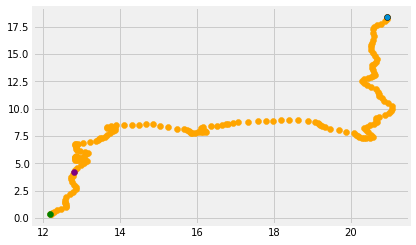

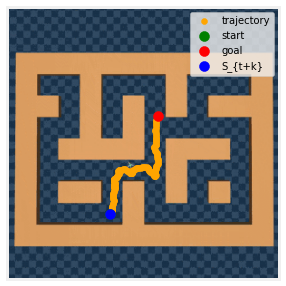

V(sg, g, g)= [-16.628887]
V(s, g, g)= [-16.460331]
Advantage of going to sg from s:  [-0.16855621]


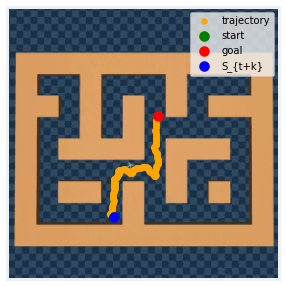

V(sg, g, g)= [-12.681805]
V(s, g, g)= [-12.736717]
Advantage of going to sg from s:  [0.05491257]


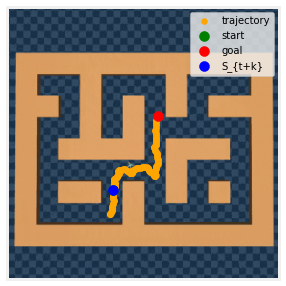

V(sg, g, g)= [-9.474525]
V(s, g, g)= [-9.6975155]
Advantage of going to sg from s:  [0.22299004]


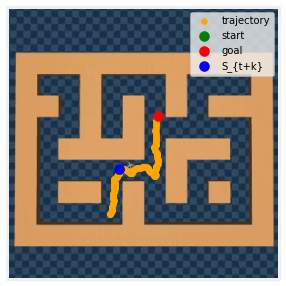

V(sg, g, g)= [-8.701987]
V(s, g, g)= [-8.722477]
Advantage of going to sg from s:  [0.02048969]


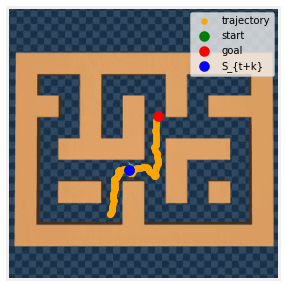

V(sg, g, g)= [-5.792803]
V(s, g, g)= [-6.462802]
Advantage of going to sg from s:  [0.6699991]


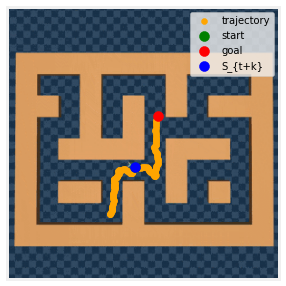

V(sg, g, g)= [-6.234605]
V(s, g, g)= [-6.682168]
Advantage of going to sg from s:  [0.44756317]


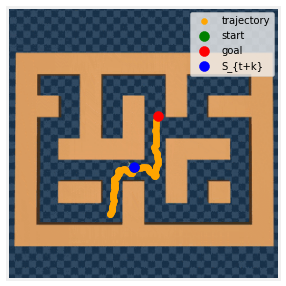

V(sg, g, g)= [-6.6152716]
V(s, g, g)= [-6.5256214]
Advantage of going to sg from s:  [-0.08965015]


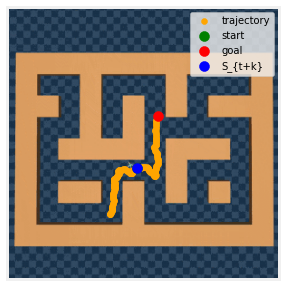

V(sg, g, g)= [-6.8658495]
V(s, g, g)= [-7.1516714]
Advantage of going to sg from s:  [0.2858219]


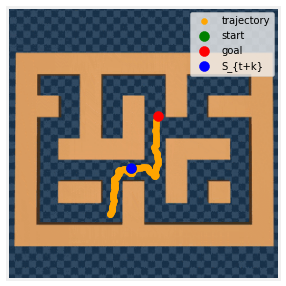

V(sg, g, g)= [-6.193521]
V(s, g, g)= [-5.8208475]
Advantage of going to sg from s:  [-0.3726735]


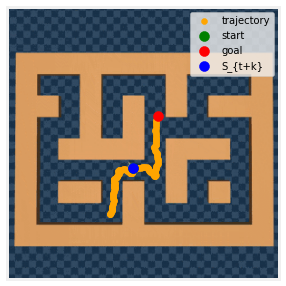

V(sg, g, g)= [-5.2391357]
V(s, g, g)= [-5.722616]
Advantage of going to sg from s:  [0.48348045]


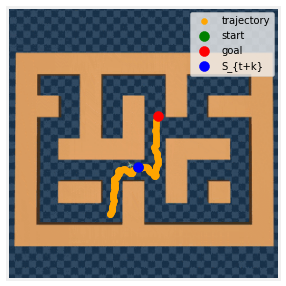

V(sg, g, g)= [-5.0671883]
V(s, g, g)= [-5.477432]
Advantage of going to sg from s:  [0.4102435]


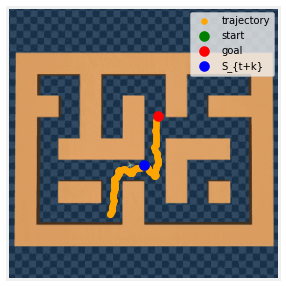

V(sg, g, g)= [-4.719483]
V(s, g, g)= [-4.321151]
Advantage of going to sg from s:  [-0.39833212]


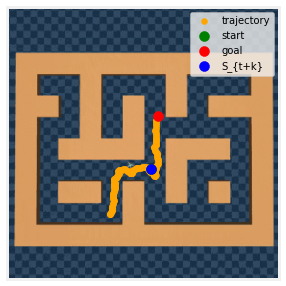

V(sg, g, g)= [-6.947296]
V(s, g, g)= [-8.696651]
Advantage of going to sg from s:  [1.7493553]


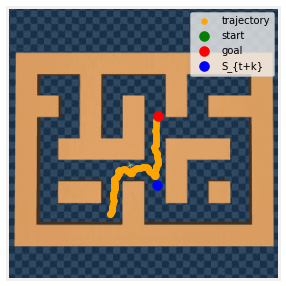

V(sg, g, g)= [-6.3478947]
V(s, g, g)= [-7.652402]
Advantage of going to sg from s:  [1.3045073]


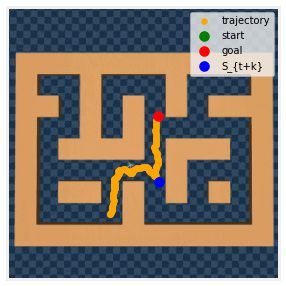

V(sg, g, g)= [-8.139362]
V(s, g, g)= [-8.564016]
Advantage of going to sg from s:  [0.424654]


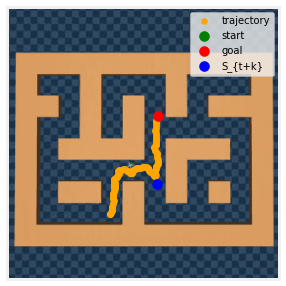

V(sg, g, g)= [-5.789251]
V(s, g, g)= [-6.925759]
Advantage of going to sg from s:  [1.136508]


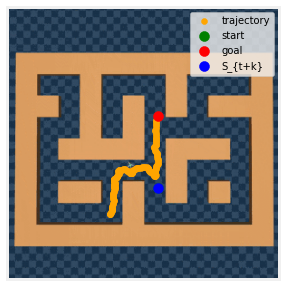

V(sg, g, g)= [-8.014718]
V(s, g, g)= [-6.9735284]
Advantage of going to sg from s:  [-1.0411897]


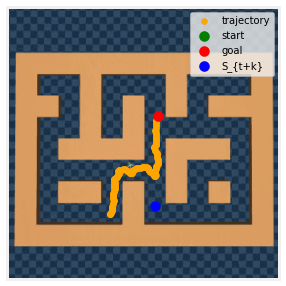

V(sg, g, g)= [-8.535439]
V(s, g, g)= [-7.468441]
Advantage of going to sg from s:  [-1.0669975]


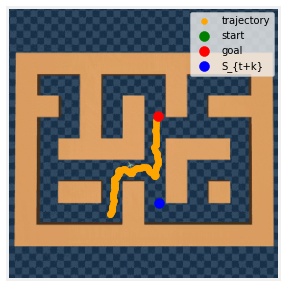

V(sg, g, g)= [-8.947536]
V(s, g, g)= [-9.152999]
Advantage of going to sg from s:  [0.20546246]


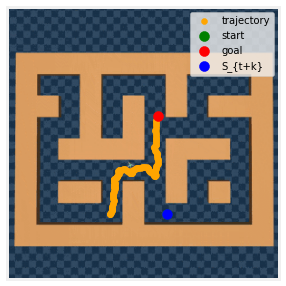

V(sg, g, g)= [-8.949353]
V(s, g, g)= [-8.65201]
Advantage of going to sg from s:  [-0.29734325]


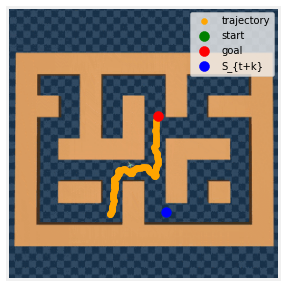

V(sg, g, g)= [-9.178949]
V(s, g, g)= [-8.72543]
Advantage of going to sg from s:  [-0.45351982]


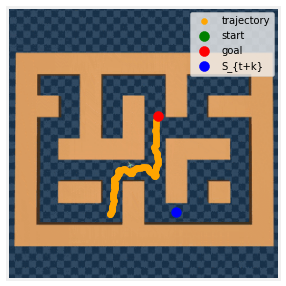

V(sg, g, g)= [-9.451318]
V(s, g, g)= [-9.806892]
Advantage of going to sg from s:  [0.3555746]


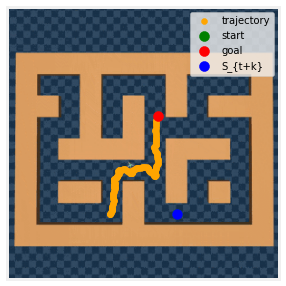

V(sg, g, g)= [-8.066245]
V(s, g, g)= [-8.12167]
Advantage of going to sg from s:  [0.05542469]


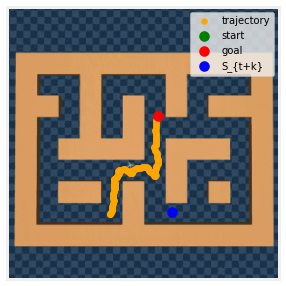

V(sg, g, g)= [-8.839512]
V(s, g, g)= [-8.995521]
Advantage of going to sg from s:  [0.15600872]


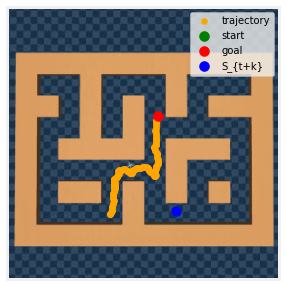

V(sg, g, g)= [-10.276225]
V(s, g, g)= [-10.398102]
Advantage of going to sg from s:  [0.12187672]


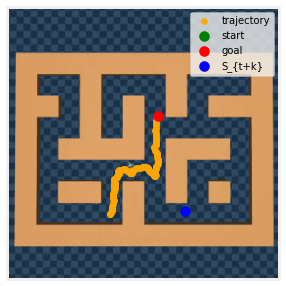

V(sg, g, g)= [-9.608902]
V(s, g, g)= [-9.153729]
Advantage of going to sg from s:  [-0.45517254]


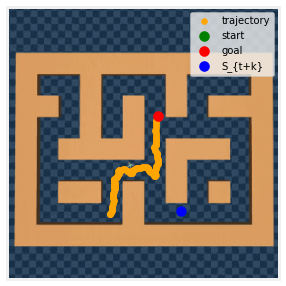

V(sg, g, g)= [-9.078512]
V(s, g, g)= [-9.067829]
Advantage of going to sg from s:  [-0.01068306]


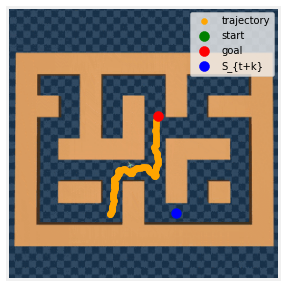

V(sg, g, g)= [-10.538922]
V(s, g, g)= [-10.588474]
Advantage of going to sg from s:  [0.04955196]


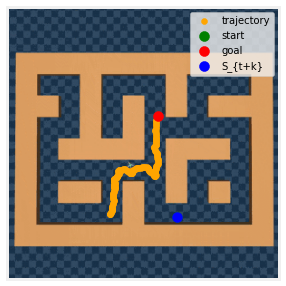

V(sg, g, g)= [-9.045656]
V(s, g, g)= [-8.688551]
Advantage of going to sg from s:  [-0.35710526]


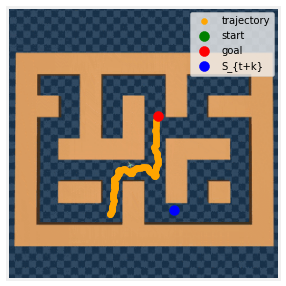

Moviepy - Building video /home/nazar/PycharmProjects/AILOT/notebooks/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nazar/PycharmProjects/AILOT/notebooks/rl-video-episode-0.mp4



TypeError: must be real number, not NoneType

In [30]:
from gymnasium.utils import save_video

sample = gc_dataset.sample(1)
# expert_trajectory = d4rl_ds['observations'][np.arange(start=1000, stop=1350)]
start_point = expert_trajectory[0]
target_goal = expert_trajectory[-1] #sample['ailot_high_goals'][0]
waypoint_goals = expert_trajectory[25] #sample['ailot_low_goals'][0]

# env.reset()
# start_point = env.env.env._wrapped_env._get_obs()

plt.scatter(expert_trajectory[:, 0], expert_trajectory[:, 1], alpha=1, label='trajectory', color='orange')
plt.scatter(*env.env.env._wrapped_env.target_goal, label="subgoal", edgecolors='black', alpha=1)
plt.scatter(start_point[0], start_point[1], alpha=1, label='start', color='green')
plt.scatter(waypoint_goals[0], waypoint_goals[1], alpha=1, label='waypoint', color='purple')

env.reset()
env.env.env._wrapped_env.set_xy((start_point[0], start_point[1]))
env.env.env._wrapped_env.set_target((target_goal[0], target_goal[1]))

sample_key = jax.random.PRNGKey(42)
curr_point = start_point
frames=[]
# env.env.env._wrapped_env.viewer.cam.lookat[0] = 18
# env.env.env._wrapped_env.viewer.cam.lookat[1] = 12
# env.env.env._wrapped_env.viewer.cam.distance = 50
# env.env.env._wrapped_env.viewer.cam.elevation = -90

for i in range(1500):
    key, sample_key = jax.random.split(sample_key, 2)
    intent = intents_learner.model(curr_point).sample(seed=key)
    # intent = intents_learner.model(target_goal).sample(seed=key)
    action = jax.device_get(actor_learner.model(curr_point.squeeze(), intent.squeeze()).sample(seed=key))
    action = jnp.clip(action, -1, 1)
    new_obs, _, _ ,_ = env.step(action)
    
    os.environ['CUDA_VISIBLE_DEVICES']='4'
    frames.append(env.render(mode='rgb_array'))
    os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
    
    if i % 50 == 0:
        print("V(sg, g, g)=", get_v_zz(icvf_model, target_goal, new_obs[None]))
        print("V(s, g, g)=", get_v_zz(icvf_model, target_goal, curr_point[None]))
        print("Advantage of going to sg from s: ", get_v_zz(icvf_model, target_goal, new_obs[None]) - get_v_zz(icvf_model, target_goal, curr_point[None]))
        
        plot_traj_image(sample, new_obs, target_goal, new_obs, "/home/m_bobrin/AILOT/notebooks/antmaze-large.png")
        plt.show()
    curr_point = new_obs
save_video.save_video(frames, video_folder='.', fps=env.env.env._wrapped_env.metadata['render_fps'])